In [76]:
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import threshold_sauvola 
import numpy as np
from skimage.exposure import is_low_contrast
from skimage.exposure import adjust_gamma
from skimage import exposure
from skimage.color import rgb2hsv
from tensorflow import keras
from skimage import exposure
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

cimage = imread('../sample_images/image2.jpg')
cimage = exposure.adjust_gamma(cimage, 1)

reconstructed_model = keras.models.load_model('keras_alphanumeric_weights.h5')

img = rgb2gray(cimage)

Estimated Gaussian noise standard deviation = 0.0007267657933850974


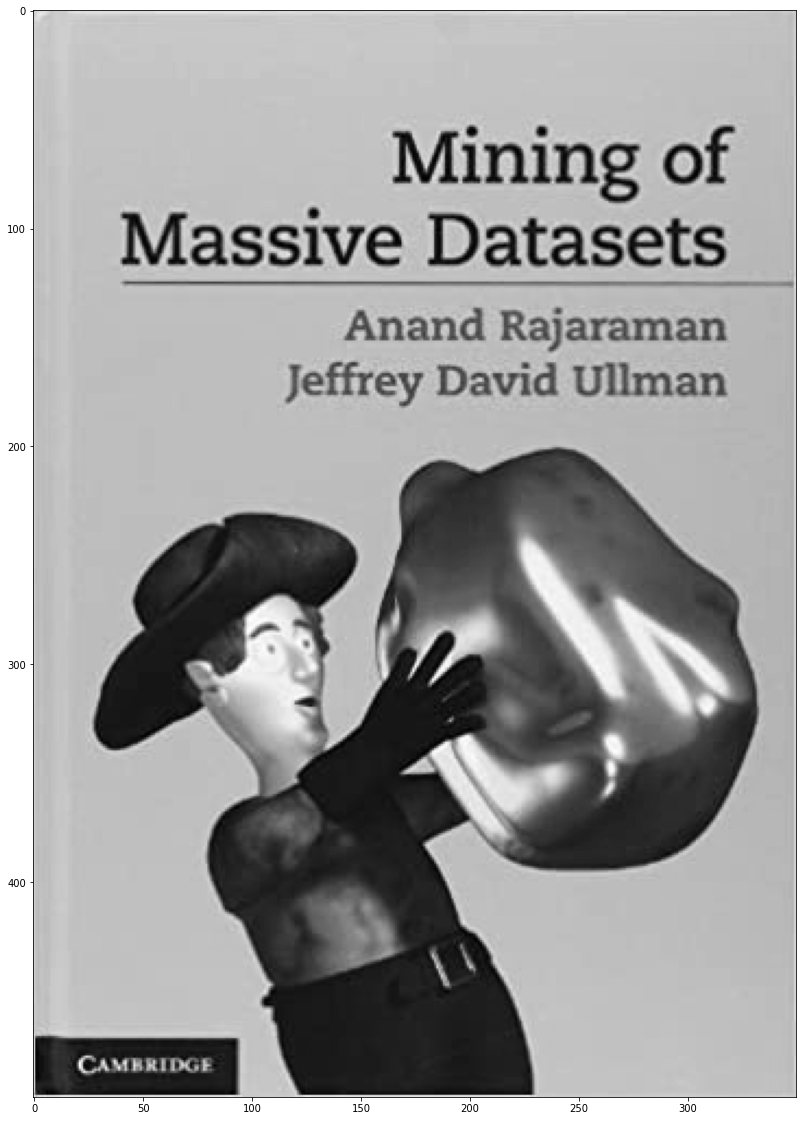

In [77]:
plt.figure(figsize=(20,20))
plt.imshow(img, cmap="gray")

In [78]:
from skimage.measure import label, regionprops
from scipy.ndimage.morphology import distance_transform_edt
import time
import pytesseract
from skimage.transform import rescale, resize
from skimage.util import invert , pad
from skimage.io import imsave
from skimage.morphology import binary_closing

final_thresholded_image = np.zeros(img.shape)

st_time = int(round(time.time() * 1000))
multilayer_prediction_map = {}
multilayer_prediction_map_recorded = []
def predict_alphanumer(img):
    #bin_char = invert(resize(np.pad(img, 5, pad_with), (32,32)) > 0.1)
    predicted = reconstructed_model.predict(rescale_for_tess(img).reshape(1,32,32,1))
   # predicted = pytesseract.image_to_string(rescale_for_tess(img), config='--psm 10')
   # print(np.max(predicted))
    max_prob = np.max(predicted)
    if max_prob < 0.2:
        return ''
    
    predicted = all_characters[np.argmax(predicted)]
    if predicted.isalnum():
        return predicted
    return ''

def rescale_for_tess(character_img):
    character_img = binary_closing(character_img)
    resized = rescale(character_img,2,multichannel=False)
    r, c = resized.shape
    rescaled = rescale(resized, np.minimum(20 / r, 20 / c), multichannel=False) > 0.1
    # fit it inside a 32 x 32 box, centered
    r, c = rescaled.shape
    r_dist = int((32 - r) / 2)
    c_dist = int((32 - c) / 2)
    digit = np.ones((32, 32), dtype=np.int8)
    digit[r_dist:r_dist + r, c_dist:c_dist + c] = invert(rescaled)
    return digit

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def round5(x):
    return int(x / 10) * 10 + 10 if (x % 10) >= 5 else int(x / 10) * 10

def is_not_recorded(region):
    centroid = list(region.centroid)
    centroid[0] = round5(centroid[0])
    centroid[1] = round5(centroid[1])
    centroid_id = str(centroid[0])+"_"+str(centroid[1])
    if centroid_id not in multilayer_prediction_map_recorded:
        return True
    return False

def remove_non_text_like_regions(image, original_gray_img):
    ret_img = np.copy(image)
    label_image = label(image)
    img_height, img_weight = image.shape
    for region in regionprops(label_image):
        if is_not_recorded(region):
            minr, minc, maxr, maxc = region.bbox
            height = maxr - minr
            width = maxc - minc
            aspect_ratio = width/height
            should_clean = region.area < 15 * (img_height * img_weight / (600**2))
            should_clean = should_clean or (region.area > (img_height*img_weight/5))
            should_clean = should_clean or aspect_ratio < 0.06  or aspect_ratio > 3
            should_clean = should_clean or region.eccentricity > 0.995
            should_clean = should_clean or region.solidity < 0.3
            should_clean = should_clean or region.extent < 0.2 or region.extent > 0.9

            strokeWidthValues = distance_transform_edt(region.image)
            flat = strokeWidthValues.flatten()
            flat = flat[flat > 0]
            coefficient_of_variation = np.std(flat)/np.mean(flat)
            should_clean = should_clean or coefficient_of_variation > 0.6
            if should_clean:
                for coord in region.coords:
                    ret_img[coord[0],coord[1]] = 0
            else:
                #imsave("/tmp/"+str(time.time())+".jpg", original_gray_img[minr:maxr, minc:maxc])
                predicted = predict_alphanumer(region.image)
                
                if len(predicted) > 0:
                    centroid = list(region.centroid)
                    centroid[0] = round5(centroid[0])
                    centroid[1] = round5(centroid[1])
                    centroid_id = str(centroid[0])+"_"+str(centroid[1])
                    if centroid_id not in multilayer_prediction_map:
                        multilayer_prediction_map[centroid_id] = []

                    multilayer_prediction_map[centroid_id].append(predicted)
                    if multilayer_prediction_map[centroid_id].count(predicted) == 2:
                        final_thresholded_image[minr:maxr, minc:maxc] = region.image
                        multilayer_prediction_map_recorded.append(centroid_id)
                
    return ret_img

# thresholding the image under different thresholds
binary_images = []
threshold_values = np.arange(0.1,0.7, 0.1)
for threshold in threshold_values:
    binary_images.append(remove_non_text_like_regions(img < threshold, img))

ed_time = int(round(time.time() * 1000))
print("total time taken:", (ed_time - st_time))

total time taken: 4704


In [79]:
multilayer_prediction_map

{'110_100': ['S', 's', 'S'],
 '110_110': ['S', 's', 's'],
 '110_130': ['l', 'l'],
 '110_140': ['V', 'v', 'v'],
 '110_160': ['e', 'e'],
 '110_190': ['D', 'D'],
 '110_210': ['a', 'a'],
 '110_220': ['a', 'a'],
 '110_230': ['t', 't'],
 '110_240': ['a', 'w'],
 '110_250': ['a', 'a'],
 '110_260': ['s', 's'],
 '110_280': ['a', 'e', 'e'],
 '110_290': ['t'],
 '110_300': ['t', 't'],
 '110_310': ['S', 'S'],
 '110_50': ['M', 'M'],
 '110_60': ['M', 'M'],
 '110_80': ['C', 'a', 'a'],
 '140_220': ['R', 'R'],
 '140_240': ['u'],
 '150_150': ['h', 'F', 'a', 'a'],
 '150_160': ['n', 'n'],
 '150_170': ['c'],
 '150_180': ['7'],
 '150_190': ['n', 'n'],
 '150_200': ['d', 'd'],
 '150_220': ['H'],
 '150_230': ['a'],
 '150_240': ['j', '1', '1'],
 '150_250': ['a', 'T'],
 '150_260': ['l', 'T', 'm'],
 '150_270': ['R', 'z'],
 '150_280': ['m', 'w'],
 '150_290': ['7'],
 '150_300': ['a'],
 '150_310': ['j', '1', 'n', 'n'],
 '170_120': ['l', 'l'],
 '170_130': ['e', 'q', 'Q'],
 '170_140': ['E', 'f', 'g', 'H'],
 '170_150': [

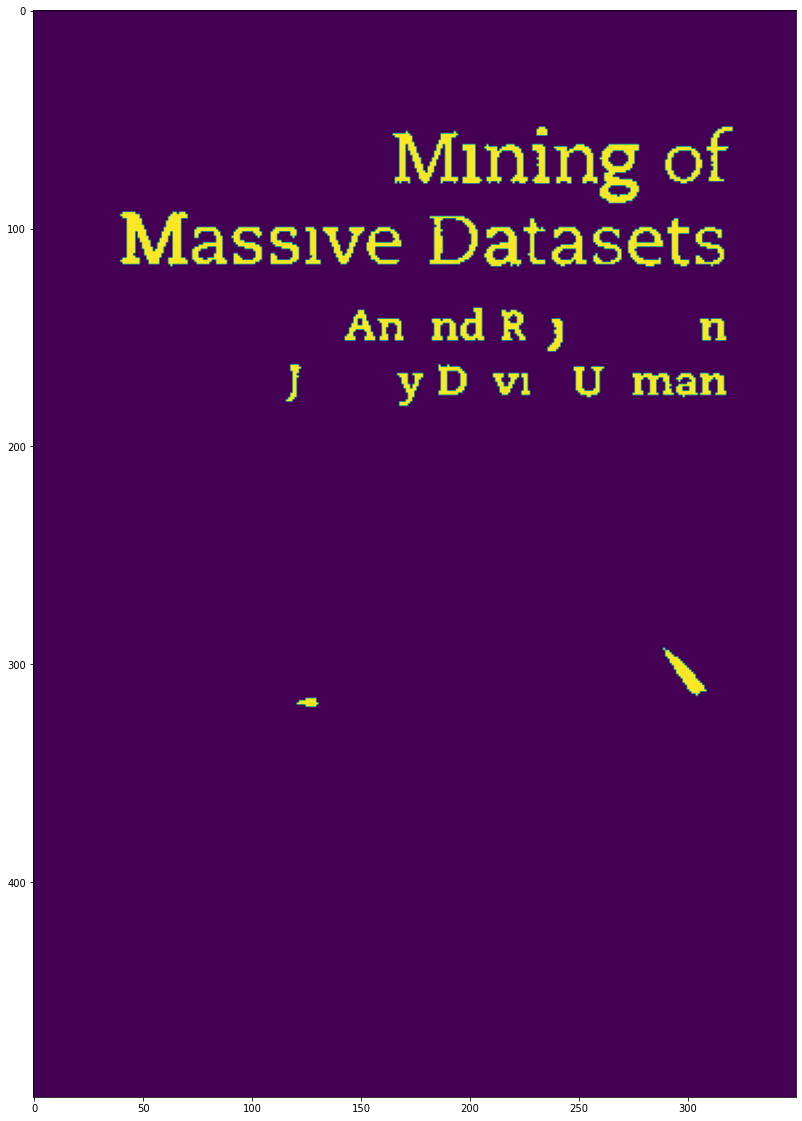

In [80]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(final_thresholded_image)
pytesseract.image_to_string(final_thresholded_image)
plt.show()

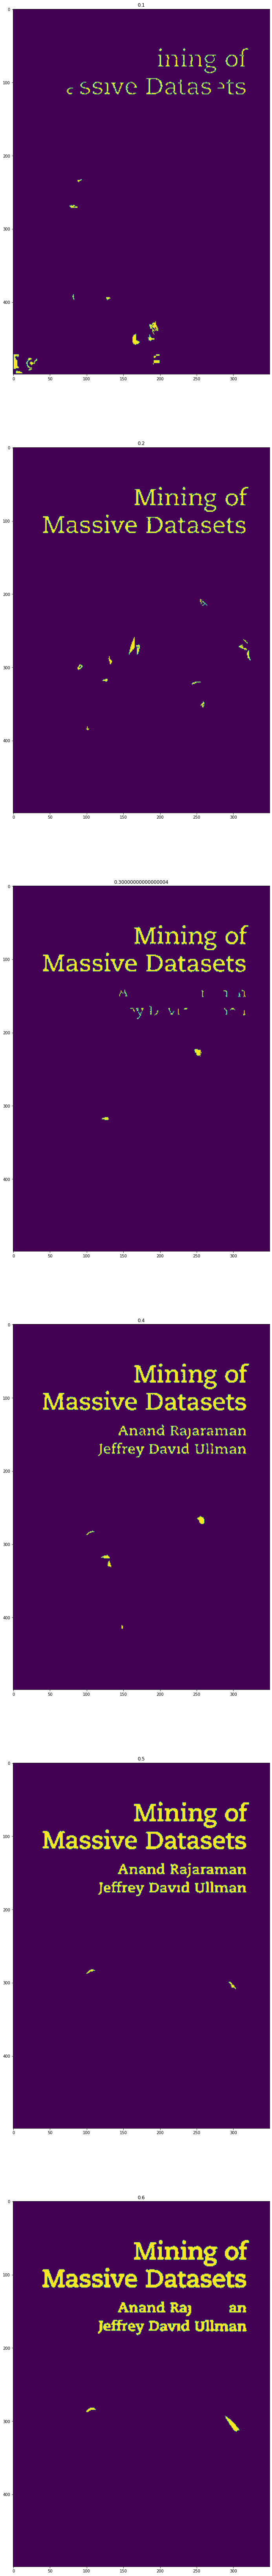

In [81]:
fig, ax = plt.subplots(nrows=len(threshold_values), figsize=(20,120))
for index, bin_img in enumerate(binary_images):
    ax[index].imshow(bin_img)
    ax[index].set_title(threshold_values[index])
plt.show()

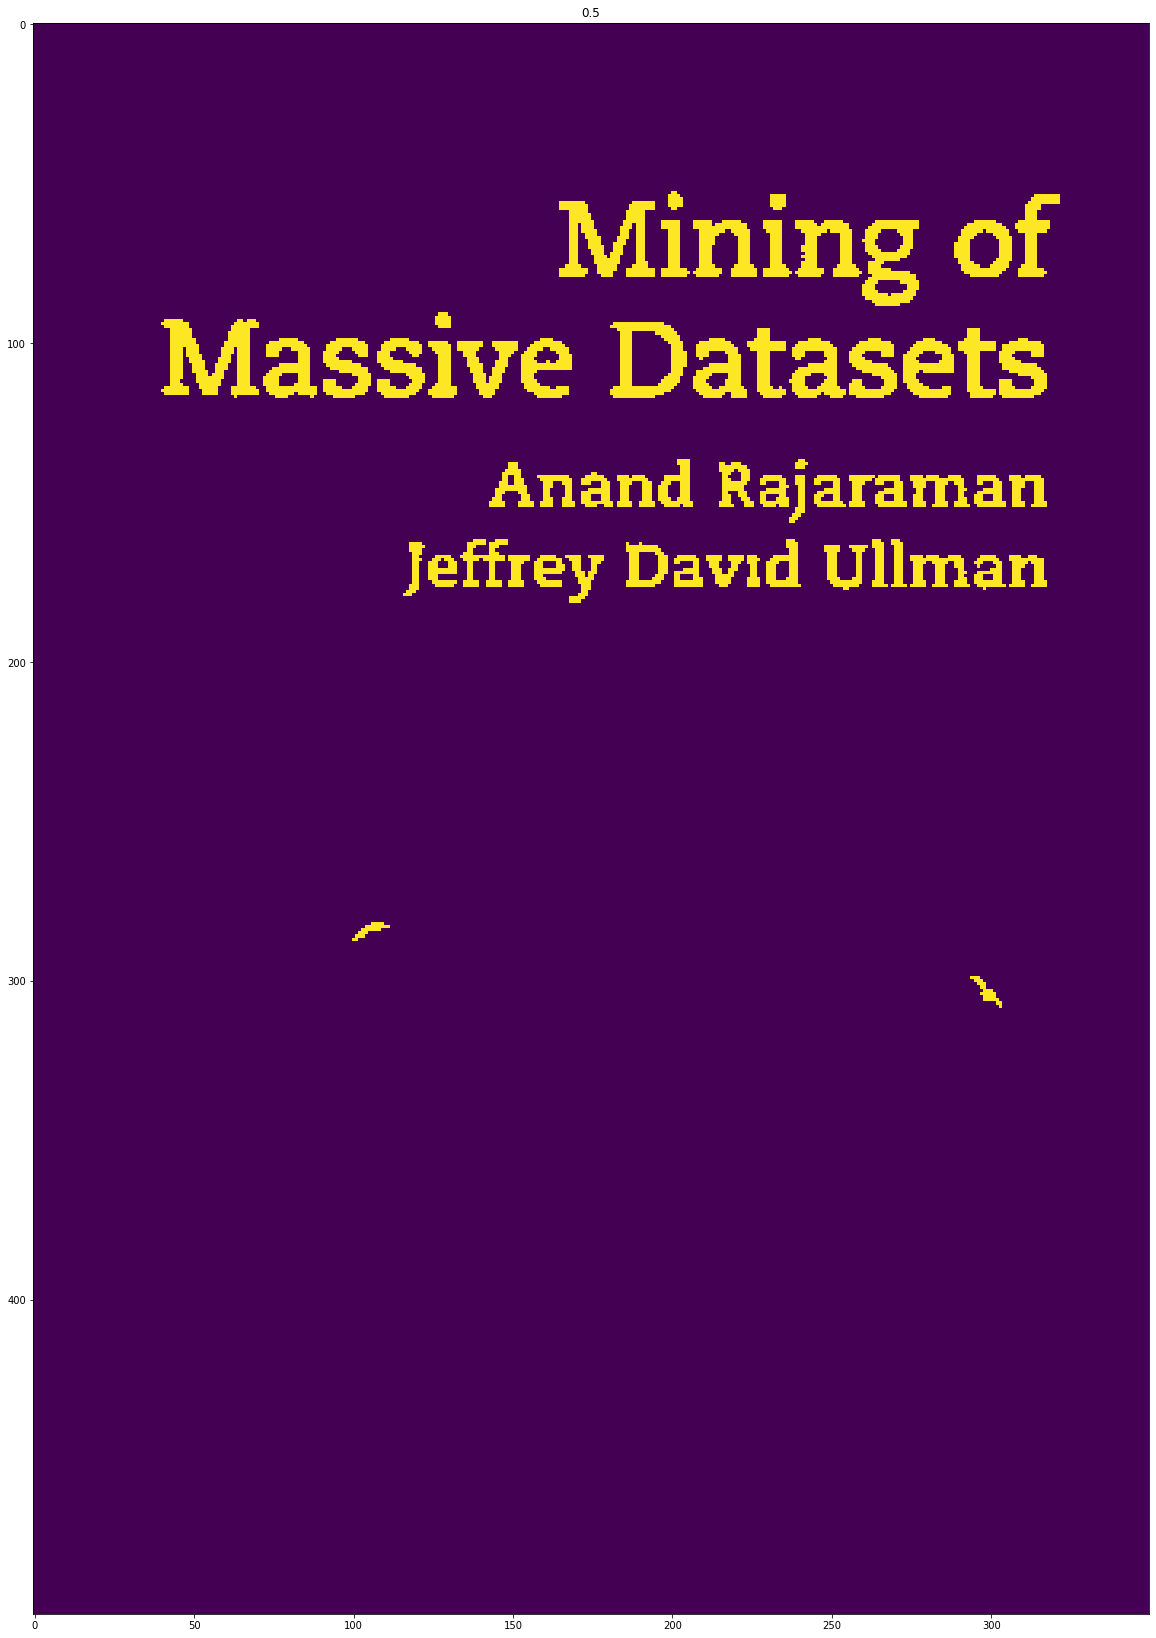

In [82]:
fig, ax = plt.subplots(figsize=(20,120))
index = 4
ax.imshow(binary_images[index])
ax.set_title(threshold_values[index])
plt.show()

T (7, 577, 159, 772)
v (7, 786, 26, 814)
o (44, 55, 79, 82)
R (44, 127, 78, 152)
e (44, 156, 79, 182)
P (44, 205, 78, 229)
o (44, 230, 79, 257)
R (44, 290, 78, 315)
0 (44, 383, 79, 408)
T (44, 445, 79, 469)
T (44, 474, 79, 498)
Y (45, 34, 79, 55)
U (45, 86, 79, 111)
U (45, 261, 79, 286)
l (45, 319, 78, 331)
N (45, 333, 78, 358)
U (45, 413, 79, 438)
A (45, 498, 78, 521)
B (47, 624, 81, 650)
R (47, 655, 81, 681)
o (47, 789, 82, 816)
5 (47, 929, 82, 953)
P (47, 958, 81, 982)
U (48, 688, 82, 712)
H (48, 716, 81, 742)
Y (48, 768, 81, 789)
U (48, 820, 82, 845)
L (48, 860, 82, 880)
L (48, 884, 82, 904)
l (48, 983, 81, 995)
L (48, 996, 82, 1016)
L (48, 1021, 81, 1041)
l (48, 1066, 71, 1078)
T (97, 43, 131, 67)
e (97, 98, 131, 124)
6 (97, 147, 131, 172)
L (97, 176, 131, 196)
A (97, 199, 130, 222)
5 (97, 230, 131, 255)
5 (97, 259, 131, 284)
H (98, 68, 130, 94)
l (98, 309, 121, 321)
o (114, 899, 141, 924)
o (198, 695, 225, 721)
e (220, 287, 352, 471)
o (335, 418, 345, 428)
o (368, 329, 378, 339)


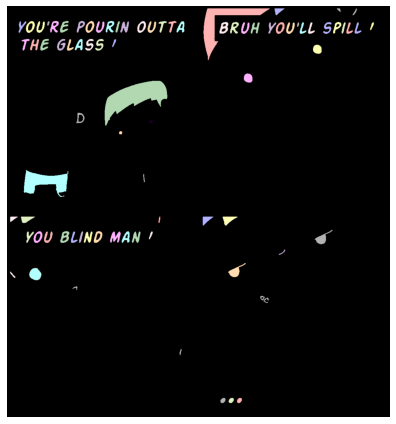

In [58]:
from skimage.measure import label, regionprops

from skimage.color import label2rgb

image_index = 4

# label image regions
label_image = label(final_thresholded_image)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=binary_images[image_index], bg_label=0)    
region_images = []
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)
for region in regionprops(label_image):
    region_images.append(region.image)
    print(predict_alphanumer(region.image) , region.bbox)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [66]:
#fig, ax = plt.subplots(nrows=len(region_images), figsize=(100,45))
for index, bin_char in enumerate(region_images):
#     ax[index].imshow(bin_char)
#     ax[index].axis("off")
#     ax[index].set_title(predict_alphanumer(bin_char))
    predicted1 = reconstructed_model.predict(rescale_for_tess(bin_char).reshape(1,32,32,1))
    predicted2 = pytesseract.image_to_string(rescale_for_tess(bin_char), config='--psm 10')
    predicted1 = all_characters[np.argmax(predicted1)]
    print(predicted1, predicted2)

T r
v a
o 0
R z
e c
P p
o 0
R ?
0 0
T 7
T 7
Y ¥
U U
U U
l 7
N x
U U
A A
B 7
R Rg
o G
5 5
P P
U U
H H
Y ¥
U U
L c
L L
l 7
L L
L c
l Z
T 7
e c
6 6
L c
A A
5 S
5 5
H H
l Z
o 
o oe
e ~
o =
o =
H my
v r
v >
l ,
v yr
v vy
o 0
B B
l 7
o D
A A
l ,
Y ¥
U U
L c
N NW
M 
N Nn
2 a
d =
o Ss
X \
o eo
o 


predicted H


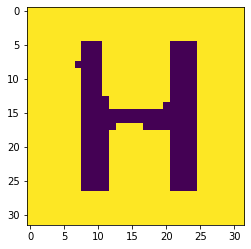

In [9]:
bin_char = invert(resize(np.pad(region_images[31], 5, pad_with), (32,32)) > 0.1)
predicted = pytesseract.image_to_string(bin_char, config='--psm 10')
print("predicted", predicted)
plt.imshow(bin_char)

5
5 0.4660305


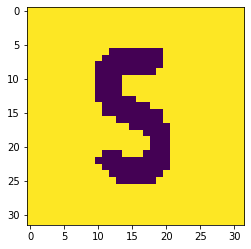

In [28]:
character = rescale_for_tess(region_images[34])
print(pytesseract.image_to_string(character, config='--psm 10'))
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
predicted = reconstructed_model.predict(character.reshape(1,32,32,1))
print(all_characters[np.argmax(predicted)], np.max(predicted))
plt.imshow(character)